In [1]:
import os, sys
sys.path.append(sys.path[0].split("lq_zprime")[0])

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif"

import nbimporter
from Heatmap_Utilities.Main_Functions import smooth, plot_heatmap

In [3]:
def approx_global_sig(sig: np.array, bkg: np.array, N: float = 0.0) -> float:
    """
    Calculates the statistical significance of a signal over background in a given dataset using a modified version of
    the formula (S -N sqrt(B))/sqrt(S+B), where S is the number of signal events, B is the number of background events,
    and N is the expected number of background events in the signal region.

    Parameters:
    sig (np.array): 1D array containing the number of signal events in each bin of the dataset.
    bkg (np.array): 1D array containing the number of background events in each bin of the dataset.
    N (float): Expected number of background events in the signal region. Default value is 0.0.

    Returns:
    float: The statistical significance of the signal over background in the dataset.
    """

    # calculate weight factor w for each bin
    w = np.log(1. + sig/(bkg + 1e-9))

    # calculate intermediate quantities
    s_w = sig * w
    b_w = bkg * w
    s_ww = sig * w ** 2
    b_ww = bkg * w ** 2

    # calculate numerator and denominator of modified formula
    num = np.sum(s_w) - N * np.sqrt(np.sum(b_ww))
    den = np.sqrt(np.sum(s_ww + b_ww))

    # calculate statistical significance and return it
    return num / den

In [4]:
signal = 'tau_tau'

bkgs =  ['tbart', 'V+jets', 'stop', 'Diboson']
Masses = ["1000", '1250', '1500', '1750', '2000', '2250', '2500']
betards = ['wRHC', 'woRHC']
suffix_by_betard = {'wRHC': '', 'woRHC': '_wo_RHC'}

channels = {'hadronic_dLQ': 'hadronic_Tau_Tau_b_b',
           'hadronic_sLQ': 'hadronic_Tau_Tau_b',
           'hadronic_non-resonant': 'hadronic_Tau_Tau',
           'semileptonic_dLQ': 'semileptonic_Tau_Tau_b_b',
           'semileptonic_sLQ': 'semileptonic_Tau_Tau_b',
           'semileptonic_non-resonant': 'semileptonic_Tau_Tau'}

XS_Dict = {}

for signal in ['ta_ta', 'zp_tau_tau']:
    Path = os.path.join(os.path.dirname(os.getcwd()), "01_signal_production", 'xs_signals_woRHC', signal, 'XS_Matrix.csv')
    
    XS_Dict[signal] = pd.read_csv(Path, index_col= 0)
    XS_Dict[signal].columns = [float(i) for i in XS_Dict[signal].columns]
    XS_Dict[signal].index = [float(i) for i in XS_Dict[signal].index]

In [5]:
XS_Dict[signal].index

Float64Index([   0.5, 0.5625,  0.625, 0.6875,   0.75, 0.8125,  0.875, 0.9375,
                 1.0, 1.0625,  1.125, 1.1875,   1.25, 1.3125,  1.375, 1.4375,
                 1.5, 1.5625,  1.625, 1.6875,   1.75, 1.8125,  1.875, 1.9375,
                 2.0, 2.0625,  2.125, 2.1875,   2.25, 2.3125,  2.375, 2.4375,
                 2.5, 2.5625,  2.625, 2.6875,   2.75, 2.8125,  2.875, 2.9375,
                 3.0, 3.0625,  3.125, 3.1875,   3.25, 3.3125,  3.375, 3.4375,
                 3.5],
             dtype='float64')

In [6]:
gU = 1.5
gU_name = str(gU).replace('.','_')

In [7]:
Significances = {'wRHC': {}, 'woRHC': {}}

#non-res:
for betard in betards:
    Significances[betard]['non-res'] = {}
    
    for Mass in Masses:
        Significances[betard]['non-res'][float(Mass)] = {} 

        for coupling in XS_Dict['zp_tau_tau'].index:
            
            Matrix_Signal = np.zeros([11,6])
            Matrix_BKG = np.zeros([11,6])
            for n, channel in enumerate(channels):
                
                Efficiences = pd.read_csv(os.path.join(f'Data_LQS2023/Efficiences', f'{channel}.csv'), index_col= 0)
                Efficience = Efficiences[f'Tau_Tau{suffix_by_betard[betard]}_{Mass}']['DeltaR > 0.3']
                XS_Total = XS_Dict['ta_ta'][float(Mass)][gU] + XS_Dict['zp_tau_tau'][float(Mass)][coupling]
                Luminosity = 137*1000
                N_events = Efficience*XS_Total*Luminosity
                
                path_to_txt = os.path.join(f'Data_LQS2023/Histograms_{betard}', f'M{Mass}', channels[channel], f"high_per_bin_tau_tau.txt")
                high_per_bin = np.loadtxt(path_to_txt)
                high_per_bin = high_per_bin/sum(high_per_bin)                

                Matrix_Signal[:, n] += high_per_bin*N_events

                for bkg in bkgs:
                    path_to_txt = os.path.join(f'Data_LQS2023/Histograms_{betard}', f'M{Mass}', channels[channel], f"high_per_bin_{bkg}.txt")
                    Matrix_BKG[:, n] += np.loadtxt(path_to_txt)                

            Signal_Data = np.asarray(Matrix_Signal.reshape((1,66)))
            BKG_Data = np.asarray(Matrix_BKG.reshape((1,66)))    
            Significances[betard]['non-res'][float(Mass)][coupling/gU] = approx_global_sig(Signal_Data, BKG_Data)

In [8]:
for betard in betards:
    file_name = f'Significances/Significance_Table_13TeV_L137_non-res_{betard}_with_gU_{gU_name}.csv'
    pd.DataFrame.from_dict(Significances[betard]['non-res']).to_csv(file_name)

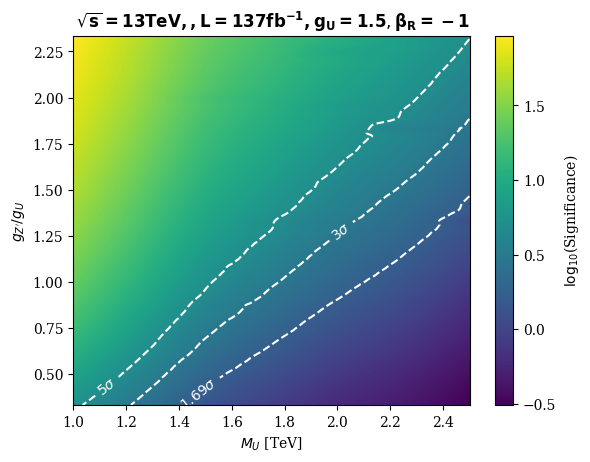

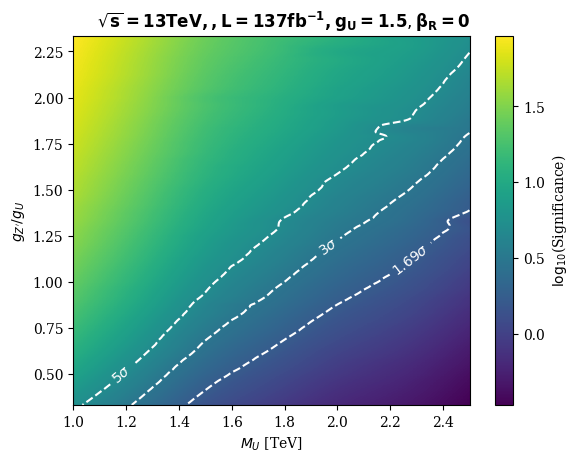

In [9]:
betard_title = {'wRHC': r'$, \mathbf{\beta_{R} = -1}$', 'woRHC': r'$, \mathbf{\beta_{R} = 0}$'}

# ubicaciones = {'non-res_wRHC': [[1600/1000,1], [1600/1000, 1.2], [1600/1000, 1.5]],
#                'non-res_woRHC': [[1600/1000,0.8], [1600/1000, 1.25], [1600/1000, 1.5]], 
#               }

def Calcular_g_U(c_U, M):
    v = 246
    return 2*np.sqrt(c_U)*M/v

for betard in betards:
    
    Data = pd.DataFrame.from_dict(Significances[betard]['non-res'])
    Data.columns = [float(column)/1000 for column in Data.columns] #TeV

    Data_interpolate = smooth(Data, log = True)
    # Data_interpolate = np.log10(Data)

    fig, ax, curves = plot_heatmap(Data_interpolate,
                           curvas_de_nivel = {np.log10(1.69) : r'$1.69 \sigma$', np.log10(3): r'$3 \sigma$', np.log10(5): r'$5 \sigma$'},
                           # curves_labels_locations= ubicaciones[f'non-res_{betard}'],
                           titulos = {'titulo':'','titulo_izquierda': '','titulo_derecha': r'$\mathbf{\sqrt{s} = 13 TeV , L = 137 fb^{-1}, g_{U} = ' + f'{gU}' + '}$' + betard_title[betard] ,'x_label': r'$M_{U}$ [TeV]', 'y_label': r'$g_{Z^{\prime}} / g_U$', 'cbar_label': r'$\log_{10}$(Significance)'}
                          )        

    file_name = f'Significances/Significance_Heatmap_13TeV_L137_non-res_{betard}_with_gU_{gU_name}.png'
    plt.savefig(file_name, bbox_inches='tight')

In [10]:
%%capture

sigma_curves = {}
for betard in betards:
    sigma_curves[betard] = {}
    
for betard in betards:
    
    Data = pd.DataFrame.from_dict(Significances[betard]['non-res'])
    Data.columns = [float(column)/1000 for column in Data.columns] #TeV

    Data_interpolate = smooth(Data, log = True)
    fig, ax, sigma_curves[betard]['non-res'] = plot_heatmap(Data_interpolate, curvas_de_nivel = {np.log10(1.69) : '' , np.log10(3): '', np.log10(5): ''})    

In [11]:
#let's save sigma_curves in order to plot curves in other jupyter notebook:
sigma_curves

{'wRHC': {'non-res': <matplotlib.contour.QuadContourSet at 0x7f540a1be1d0>},
 'woRHC': {'non-res': <matplotlib.contour.QuadContourSet at 0x7f5409becdf0>}}

In [12]:
# import pickle

# file = open("Significances/sigma_curves_137.pkl","wb")
# pickle.dump(sigma_curves,file)
# file.close()